# Topic Modelling with Latent Dirichlet Allocation on FOMC Meeting Minutes 
(Hit the little double arrow button above and select 'Restart and Run All Cells' to run the document)
## Conan Tan

# Introduction

This is a little project that I put together to better understand topic modelling, specifically Latent Dirichlet Allocation (LDA), by analyzing minutes from 70 different FOMC meetings ranging from 2009-2018. Topic Modelling is the process of taking a set of documents and classifying them into certain topics to abstract the documents core meaning. This project takes 70 meeting minutes and separates them into 5 different topics. From these topics, we try and analyze the meanings behind the topics and their correlation.

In [ ]:
#Import libraries
%matplotlib inline
import requests, re, pyLDAvis.sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from ipywidgets import widgets, interactive
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction import text #edit stop word list
from sklearn.model_selection import GridSearchCV #grid searchs to find optimal parameters for LDA
from collections import Counter 
from nltk.stem.snowball import EnglishStemmer

In [ ]:
#Missing meetings 20140618, 20131218, 20100316, 20090128,20091104, # 20080130, 20080318, 20080430, 20080625, 20080805, 20080916, 20081029, 20081216] 
meetingDates = [  20180131, 20180321, 20180502, 
                  20170201, 20170315, 20170503, 20170614, 20170726, 20170920, 20171101, 20171213, 
                  20160127, 20160316, 20160427, 20160615, 20160727, 20160921, 20161102, 20161214, 
                  20150128, 20150318, 20150429, 20150617, 20150729, 20150917, 20151028, 20151216, 
                  20140129, 20140319, 20140430, 20140730, 20140917, 20141029, 20141217, 
                  20130130, 20130320, 20130501, 20130619, 20130731, 20130918, 20131030, 
                  20120125, 20120313, 20120425, 20120620, 20120801, 20120913, 20121024, 20121212,
                  20110126, 20110315, 20110427, 20110622, 20110809, 20110921, 20111102, 20111213,
                  20100127, 20100428, 20100623, 20100810, 20100921, 20101103, 20101214,
                  20090318, 20090429, 20090624, 20090812, 20090923, 20091216]


In [ ]:
#Recursively add tag's string to returnable string
def recursiveTagSearch(text, tag, last):  
  #skip if string is None
  if tag.string == None:
    return recursiveTagSearch(text, tag.next, last)
  if tag.string != last:
    text += tag.string
  if tag.next.string == 'Voting for this action:':
    return text
  else:
    return recursiveTagSearch(text, tag.next, tag.string)

In [ ]:
#Scrapes Fed website for FOMC meeting minutes
def FOMCscrapper():
  baseURL = 'https://www.federalreserve.gov/monetarypolicy/fomcminutes'
  minutes = [] 
  #Iterate through FOMC Meeting Dates and append selected text to list
  for date in meetingDates:
    currentURl = baseURL + str(date) + '.htm'
    page = requests.get(currentURl)
    soup = BeautifulSoup(page.content, 'html.parser')
    print('Scrapping meeting date:', date)
    minutes.append(recursiveTagSearch('',soup.find('strong', text = re.compile('^Developments')), ''))
  return minutes

# Data Gathering and Preprocessing

We begin by building our corpus (a collection of text) by scraping the Federal Reserve website for meeting minutes from the years 2009-2018. I was only able to gather 70 meeting minutes since some meetings had special HTML tags that were not compatible with my scraper. After fetching the data, we begin the preprocessing phase by stemming the text. Stemming is the process of taking a word, or token, and reducing it into its root word. For example, any plurals or possessives such as "Dogs" or "Powell's" is changed to "Dog" and "Powell". Next, we remove any stop words from our data. Stop words are common words that are likely to appear frequently in our data and add no insightful value. It seems that the FOMC references their time frames in months. Let's remove the names of months from the data since they do not seem to add value. Remember the data has already been stemmed so to remove the months, we must specify the stemmed name of the months.

In [ ]:
#Load documents into array
minutes = FOMCscrapper()

In [ ]:
#Stem each word in doc
stemmer = EnglishStemmer()
analyzer = CountVectorizer().build_analyzer()

for i in range(len(minutes)):
    tokenList = analyzer(minutes[i])
    for j in range(len(tokenList)):
        tokenList[j] = stemmer.stem(tokenList[j])
    minutes[i] = ' '.join(tokenList)

#Adjust stopwords as preferred, testing without months. 
stopWords = ['januari', 'februari', 'march', 'april', 'june', 'juli', 'septemb', 'august','novemb', 'octob', 'decemb']
stopWords = text.ENGLISH_STOP_WORDS.union(stopWords)

# Creating the Document Term Matrix and the LDA Model

Our data is currently characterized as a list of 70 items where each item is a string containing the entire meeting's minutes. Before we can use LDA, we must create a document term matrix (DTM). A document term matrix describes the frequency of words in a collection of documents. Intuitively, you can think of a DTM as a two-dimensional list of N documents where each document is represented by another list M words (every word in the corpus) long that keeps count of the frequency of that word. Now we can finally use Latent Dirichlet Allocation to topic model our collection of data! 

# A Brief Introduction to Latent Dirichlet Allocation

LDA is a topic modelling technique that utilizes a bag of words approach. It states that any corpus is comprised of K number of topics. Each topic then consists of a set of words that come directly from the documents. After the topics and the topic words are identified, LDA will then assign two probabilities: the probability that a document belongs in a specific topic and the probability that a word belongs in that topic. This, of course, is a surface level view of LDA. For more in-depth information, check out http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/ and for the statistically savvy https://ai.stanford.edu/~ang/papers/jair03-lda.pdf.

After some mathematical wizardry courtesy of David Blei et al (2003), LDA took our 70 documents which consisted of 2320 unique words and created 5 topic groups (a number predetermined by me). Let's now analyze our documents and our topics!

In [ ]:
#Create document term matrix using count vectorizer for LDA
countVectorizer = CountVectorizer(max_df = .5, stop_words = stopWords, lowercase = True)
countVectorized = countVectorizer.fit_transform(minutes)

#Create document term matrix using Term Frequency - Inverse Document Frequency for comparison
tfidfVectorizer = TfidfVectorizer(max_df = .5, stop_words = stopWords, lowercase = True)
tfidfVectorized = tfidfVectorizer.fit_transform(minutes)

In [ ]:
#Create LDA model
topicNum = 5

ldaModel = LatentDirichletAllocation(n_components = topicNum, learning_method = 'batch', learning_decay = .9, random_state = 94)
ldaModelFit = ldaModel.fit_transform(countVectorized)
print('Document Term Matrix Shape: (N docs, M Words)', countVectorized.shape, '\n')
print('LDA Vector Shape(N Docs, K Topics):', ldaModelFit.shape)

In [ ]:
#Make meeting dates suitable for printing
printDates = []
for i in range(len(meetingDates)):
    printDates.append('Document ' + str(i) + ' - ' + str(meetingDates[i]))
    
#Create interactive widgets for visualization
documents = widgets.Dropdown(
    options = printDates,
    value = printDates[8],
    description = 'Documents'
)
topWords = widgets.IntSlider(
    value = 15,
    min = 0,
    max = 30,
    description = "N Words",
    readout_format = 'd'
)

# Word Frequency Counter, TF-IDF Score, and Topic Distribution

Here we have a small interactive visualization that allows you to choose a document to view its word frequency distribution, TF-IDF score, as well as its topic distribution. The Term Frequency - Inverse Document Frequency (TF-IDF) is a metric to measure how important a term is to a document. Higher scores indicate the term is rarer to the given document and more emphasis should be placed during analysis. Comparisons between word frequency and TF-IDF showcase how some words might not be as important as its simple frequency depicts. Topic distribution refers to the probability that a document falls into the selected topic. Documents that are strongly associated with a topic will have few and strong bars.



From this visualization, we can see the general topics that are talked about during the meeting as well as how much of an emphasis is put on that topic. Looking specifically at document 8 with meeting date 20170920, the meeting immediately following the severe hurricane season of 2017, we can see that the highest occurring words are in fact relating to the storms. The top words "hurricane" and "harvey" also carry high TF-IDF scores showing that these words are very unique to this document. Furthermore, it has nearly a 100% association with topic 5. More on this meeting later.

In [ ]:
#Get word frequencies for specified docs
def getTopWords(vectorizer, vectorized, docNum, n):
    featureNames = list(vectorizer.get_feature_names())
    counts = vectorized[docNum].sum(axis=0).A1
    freqDistribution = Counter(dict(zip(featureNames, counts))).most_common(n)
    xValues = [val[0] for val in freqDistribution]
    yValues = [val[1] for val in freqDistribution]
    xValues.reverse()
    yValues.reverse()
    return [xValues, yValues]

In [ ]:
#Print bar chart showing top N words of a document
def plotFreqDist(topWords, documents):
    
    docNum = int(documents.split()[1])
    
    #Adjust error where pyLDAvis and sklearn LDA have different topic orderings
    topicsReorder = [ldaModelFit[docNum][1], ldaModelFit[docNum][3], ldaModelFit[docNum][2],
                     ldaModelFit[docNum][4], ldaModelFit[docNum][0]]
    
    #Create plot
    plt.figure(figsize =(14,10))
    wordFreqDist = plt.subplot(2,2,1)
    tfidfDist = plt.subplot(2,2,2)
    topicDist = plt.subplot(2,2,3)

    countVect = getTopWords(countVectorizer, countVectorized, docNum, topWords)
    tfidfVect = getTopWords(tfidfVectorizer, tfidfVectorized, docNum, topWords)
    wordFreqDist.barh(countVect[0], countVect[1], color = 'y')
    tfidfDist.barh(tfidfVect[0], tfidfVect[1], color = 'm')
    topicDist.bar([1,2,3,4,5],topicsReorder, color = 'c')
    
    title = 'Document '+ str(docNum)
    ylabel = 'Top ' + str(topWords) + ' Terms'
    plt.suptitle(title)
    wordFreqDist.set_title('Word Frequency')
    wordFreqDist.set_ylabel(ylabel)
    wordFreqDist.set_xlabel('Frequency')
    tfidfDist.set_title('TF-IDF Score')
    tfidfDist.set_xlabel('p')
    topicDist.set_title('Topic Probability')
    topicDist.set_ylabel('Prob')
    topicDist.set_xlabel('Topics')
    plt.show()

interactive(plotFreqDist, topWords = topWords, documents = documents)

# The Final LDA Visualization

Finally, we have a visualization that sums up the entire LDA model. On the left, we have a intertopic distance map. The size of the topic refers to its overall weight in the model and the distances show how related the topics are to one another. On the right, we have a count of the words that appear in the document. Clicking on a topic shows the words that most contribute to that topic. Grey indicates the total count of that word in the entire corpus, while the red shading shows the proportion of that count that was used in the specified topic. The lamda slider sorts the words based on its relative weighting to that topic. A lower value shows words that more uniquely correlate with that topic, while a value of 1 sorts by word frequency in that topic (red shading). Let's begin some analysis into the topics and the words that comprise the topics! 

In [ ]:
#Create pyLDA visualization 
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(ldaModel, countVectorized, countVectorizer, mds = 'tsne')
panel

# Analysis

Each topic is fairly unique exhibited by the spread of the distance map and lack of any overlap. Upon inspection of each topic, it is clear that the topics are grouped by timeframes. If the years are not a big enough give away enough for you, let's examine topic 4. Set lambda to 0.6, which is thought to provide the most interpretable words for discerning topics from one another. The first 5 words are "2009", "2010, "talf", "loss", and "2008". The most prominent thing to me at first was "talf". Mainly because I had no idea what that word meant. Term Asset Backed Securities Loan Facility (TALF) is a Federal Reserve stimulus program created in 2008 that lasted until 2010 that promoted consumer spending through the issuance of asset backed securities. Going through the rest of the topics, you can find all sorts of little connections like that between the words.

Topic 5 provides the most unique bag of words. It is the least weighted topic depicted by its small diameter. However, every word relates to the tropical storms that occured in 2017. While this topic only captured one specific document mentioned earlier, it shows that particular meeting was unique enough to command its own entire topic. If you continue to inspect the topics and the document topic distributions above, you will continue to see trends in groupings based on time. 

# Limitations and Future Expansion

The largest limitation faced in this project was in fact the corpus itself. After removal of words that occurred in X percent of documents, the unique word count dropped dramatically. The meeting minutes shared a lot of similarity in both formatting and in word structure. While that provided ease in web scraping, it limited the overall model strength. 

This was only my first attempt at unsupervised machine learning models and was a great learning exercise. There are several areas that I wish to expand on in the near future. The corpus should be expanded to capture FOMC meetings prior to the recession to gather a more holistic view of the evolution of the meetings post crisis. The preprocessing phase as well as tuning and experimentation with the LDA hyper parameters could be refined for better more interpretable results. Removal of years from the token list and then having a human attempt to classify topic years may prove as a strong cross validation of the model. I will hopefully expand on this particular project in the future, if not I will at least take everything I learned and apply it to the next one.  

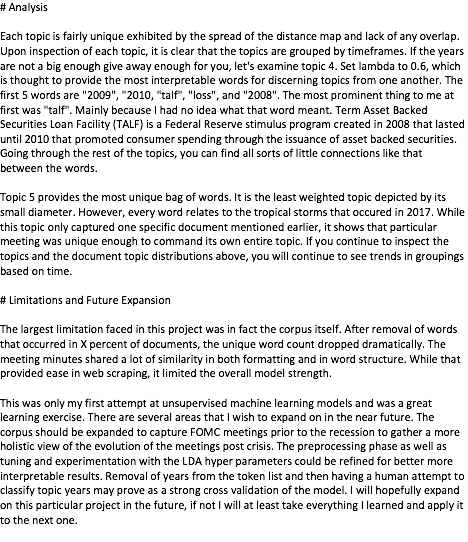